In [1]:
#import potrebnih biblioteka
%matplotlib inline
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
import collections
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

import matplotlib.pylab as pylab
#pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

In [11]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilatacija(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erozija(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)
def scale_to_range(image): #skalira elemente slike na opseg od 0 do 1
    return image/255
def select_candidates(original, image_bin):
    import collections
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    regions = {}
    for contour in contours: # za svaku konturu   
        x,y,w,h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)
        if area > 100 and h < 100 and h>15 and w>20:
            region = cv2.resize(image_bin[y:y+h+1,x:x+w+1],(28,28), interpolation = cv2.INTER_NEAREST)##resize
            regions[x] = region       
            cv2.rectangle(original,(x,y),(x+w,y+h),(0,255,0),2)
    sortiran = collections.OrderedDict(sorted(regions.items()))
    return original, sortiran.values()

def prepare_for_NN(regions):
    ready = []
    for region in regions:
        scale =scale_to_range(region)
        ready.append(scale.flatten())
    return ready
def convert_output(outputs):
    nn_outputs = []
    for index, out in enumerate(outputs):
        output = np.zeros(len(outputs))
        output[index] = 1
        nn_outputs.append(output)
    return nn_outputs
def winner(outputs):
    return max(enumerate(outputs),key=lambda x: x[1])[0]
def display_result(results, data):
    result = []
    for res in results:
        result.append(data[winner(res)])
    return result
     


In [3]:
def NN_train(X_train, y_train):
    print len(X_train[0]), len(y_train[0]) #da budem siguran u dimenzije
    X_train = np.array(X_train, np.float32)
    y_train = np.array(y_train, np.float32)
    model = Sequential()
    model.add(Dense(input_dim=784, output_dim=128,init="glorot_uniform"))
    model.add(Activation("sigmoid"))
    model.add(Dense(input_dim=128, output_dim=10,init="glorot_uniform"))
    model.add(Activation("sigmoid"))

    sgd = SGD(lr=0.005, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd)

    model.fit(X_train, y_train, nb_epoch=2000, batch_size=1, verbose = 0,shuffle=False,show_accuracy = False)
    score = model.evaluate(X_train, y_train, batch_size=1)
    
      
    return model

In [4]:
image_color = load_image('images/brojevi.png')
img = invert(image_bin(image_gray(image_color)))

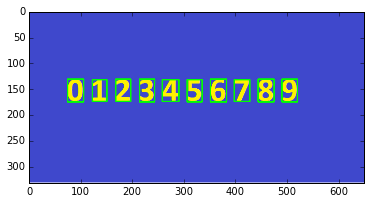

In [5]:
img_bin = erozija(dilatacija(img))
selected, numbers = select_candidates(image_color.copy(),img)
display_image(selected)


In [6]:
brojevi = [0,1,2,3,4,5,6,7,8,9]


In [7]:
inputs = prepare_for_NN(numbers)
outputs = convert_output(brojevi)
model = NN_train(inputs, outputs)
print model

784 10
10/10 [==============================] - 0s     


In [13]:
result = model.predict(np.array(inputs[2:4], np.float32))
print result

[[ 0.02471051  0.03451015  0.93897559  0.0252433   0.01880786  0.0078922
   0.00893871  0.03370299  0.01834755  0.00838612]
 [ 0.00996435  0.01003323  0.02243772  0.93776334  0.0165445   0.03531715
   0.00365455  0.01867418  0.03408204  0.02890809]]


In [14]:
print display_result(result, brojevi)

[2, 3]


[2, 3, 5, 6, 8, 9, 1, 0]


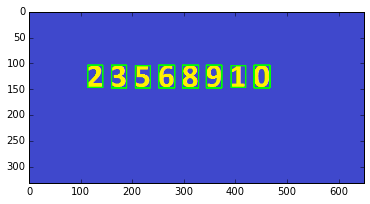

In [16]:
test_color = load_image('images/test.png')
test = invert(image_bin(image_gray(test_color)))
test_bin = erozija(dilatacija(test))
selected_test, test_numbers = select_candidates(test_color.copy(),test_bin)
display_image(selected_test)
test_inputs = prepare_for_NN(test_numbers)
result = model.predict(np.array(test_inputs, np.float32))
print display_result(result, brojevi)